# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 

# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


# Part 2. Getting Started- Load Python Packages

## 2.1. Install all the packages through FinRL library

## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRL-Tutorials-Learn/.venv/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## 2.4. Create Folders

In [3]:
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Part 3. Download Data

Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date=TRAIN_START_DATE,
                     end_date=TEST_END_DATE,
                     ticker_list=DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (97013, 8)


In [7]:
df.to_csv(f'DOW_30_TICKER_{TRAIN_START_DATE}_{TEST_END_DATE}.csv')

In [5]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,6.447412,7.643214,7.660714,7.622500,493729600,AAPL,0
1,2010-01-04,40.915886,57.720001,57.869999,56.630001,5277400,AMGN,0
2,2010-01-04,32.992153,40.919998,41.099998,40.810001,6894300,AXP,0
3,2010-01-04,43.777554,56.180000,56.389999,55.720001,6186700,BA,0
4,2010-01-04,39.883896,58.549999,59.189999,57.650002,7325600,CAT,0


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
97008,2023-02-28,463.423584,475.940002,483.359985,482.670013,3902100,UNH,1
97009,2023-02-28,217.388611,219.940002,221.770004,220.000000,5385400,V,1
97010,2023-02-28,34.428703,38.810001,38.970001,38.700001,16685300,VZ,1
97011,2023-02-28,31.987909,35.529999,35.779999,35.480000,8847000,WBA,1
97012,2023-02-28,46.214355,47.376667,47.549999,47.000000,18054000,WMT,1


In [6]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,6.447412,7.643214,7.660714,7.622500,493729600,AAPL,0
1,2010-01-04,40.915886,57.720001,57.869999,56.630001,5277400,AMGN,0
2,2010-01-04,32.992153,40.919998,41.099998,40.810001,6894300,AXP,0
3,2010-01-04,43.777554,56.180000,56.389999,55.720001,6186700,BA,0
4,2010-01-04,39.883896,58.549999,59.189999,57.650002,7325600,CAT,0


In [11]:
df.tic.unique()

array(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
       'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT',
       'DOW'], dtype=object)

In [12]:
df.tic.value_counts()

tic
AAPL    3311
AMGN    3311
WMT     3311
WBA     3311
VZ      3311
V       3311
UNH     3311
TRV     3311
PG      3311
NKE     3311
MSFT    3311
MRK     3311
MMM     3311
MCD     3311
KO      3311
JPM     3311
JNJ     3311
INTC    3311
IBM     3311
HON     3311
HD      3311
GS      3311
DIS     3311
CVX     3311
CSCO    3311
CRM     3311
CAT     3311
BA      3311
AXP     3311
DOW      994
Name: count, dtype: int64

In [20]:
## 查找DOW数据
dow_data = df[df['tic'] == 'DOW']
dow_data

,date,open,high,low,close,volume,tic,day
67202,2019-03-20,37.268902,49.799999,53.500000,52.750000,2350800,DOW,2
67232,2019-03-21,36.655228,48.980000,50.000000,49.990002,1764700,DOW,3
67262,2019-03-22,36.370850,48.599998,49.950001,48.799999,844700,DOW,4
67292,2019-03-25,36.782455,49.150002,49.400002,48.599998,440900,DOW,0
67322,2019-03-26,36.557945,48.849998,49.750000,49.000000,504700,DOW,1
...,...,...,...,...,...,...,...,...
96872,2023-02-22,52.079792,57.009998,57.435001,56.779999,3735400,DOW,2
96902,2023-02-23,52.244225,57.189999,57.720001,57.410000,4154000,DOW,3
96932,2023-02-24,52.792336,57.790001,57.875000,56.360001,4831800,DOW,4
96962,2023-02-27,52.699860,56.990002,57.639999,57.380001,5443100,DOW,0


In [23]:
## 查找NA的数据
na_data = df[df['close'].isna()]
na_data

,date,open,high,low,close,volume,tic,day


# Part 4: Preprocess Data

Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=True,
                     user_defined_feature=False)
processed = fe.preprocess_data(df)
processed.head()

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2010-01-04,6.447412,7.643214,7.660714,7.622500,493729600,AAPL,0,0.0,7.702488,7.584298,100.0,66.666667,100.0,7.622500,7.622500,0.0
1,2010-01-04,40.915886,57.720001,57.869999,56.630001,5277400,AMGN,0,0.0,7.702488,7.584298,100.0,66.666667,100.0,56.630001,56.630001,0.0
2,2010-01-04,32.992153,40.919998,41.099998,40.810001,6894300,AXP,0,0.0,7.702488,7.584298,100.0,66.666667,100.0,40.810001,40.810001,0.0
3,2010-01-04,43.777554,56.180000,56.389999,55.720001,6186700,BA,0,0.0,7.702488,7.584298,100.0,66.666667,100.0,55.720001,55.720001,0.0
4,2010-01-04,39.883896,58.549999,59.189999,57.650002,7325600,CAT,0,0.0,7.702488,7.584298,100.0,66.666667,100.0,57.650002,57.650002,0.0


In [14]:
processed.shape

(96019, 17)

In [15]:
processed.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
96014,2023-02-28,463.423584,475.940002,483.359985,482.670013,3902100,UNH,1,-2.430826,504.712172,470.724834,44.463675,-106.917587,14.202016,488.230668,506.024999,8.01119
96015,2023-02-28,217.388611,219.940002,221.770004,220.000000,5385400,V,1,-0.482196,235.240342,217.158659,50.812875,-101.962880,20.882731,225.404334,218.501501,8.01119
96016,2023-02-28,34.428703,38.810001,38.970001,38.700001,16685300,VZ,1,-0.399344,42.371731,38.144270,45.685824,-152.580187,27.749789,40.276000,39.590667,8.01119
96017,2023-02-28,31.987909,35.529999,35.779999,35.480000,8847000,WBA,1,-0.303391,37.537169,35.459830,44.313136,-154.500138,6.157708,36.424333,37.676500,8.01119
96018,2023-02-28,46.214355,47.376667,47.549999,47.000000,18054000,WMT,1,-0.075033,49.063784,46.409216,47.329878,-61.906745,3.339266,47.683000,48.174333,8.01119


#### 查找processed中处理掉的数据，查找后发现去除掉了所有tic=DOW的数据

In [19]:
import pandas as pd

# 假设 df 和 processed 是您的两个数据框
# 合并数据框，标记出现在 df 中但不在 processed 中的行
merged = df.merge(processed, on=['date', 'tic'], how='left', indicator=True)

# 筛选出那些在 processed 中不存在的行
missing_in_processed = merged[merged['_merge'] == 'left_only']
missing_in_processed
# # 只保留 date 和 tic 列
# missing_data = missing_in_processed[['date', 'tic',]]
# 
# missing_data

,date,open_x,high_x,low_x,close_x,volume_x,tic,day_x,open_y,high_y,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,_merge
67202,2019-03-20,37.268902,49.799999,53.500000,52.750000,2350800,DOW,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
67232,2019-03-21,36.655228,48.980000,50.000000,49.990002,1764700,DOW,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
67262,2019-03-22,36.370850,48.599998,49.950001,48.799999,844700,DOW,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
67292,2019-03-25,36.782455,49.150002,49.400002,48.599998,440900,DOW,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
67322,2019-03-26,36.557945,48.849998,49.750000,49.000000,504700,DOW,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96872,2023-02-22,52.079792,57.009998,57.435001,56.779999,3735400,DOW,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
96902,2023-02-23,52.244225,57.189999,57.720001,57.410000,4154000,DOW,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
96932,2023-02-24,52.792336,57.790001,57.875000,56.360001,4831800,DOW,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
96962,2023-02-27,52.699860,56.990002,57.639999,57.380001,5443100,DOW,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [24]:
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf, 0)

In [25]:
processed.sample(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
18435,2012-07-11,23.467871,29.299999,29.740000,29.709999,39184900,MSFT,2,0.064440,31.104762,29.234238,47.027421,-34.105311,1.460362,29.816333,30.342667,30.374829
90876,2022-06-14,79.484833,84.500000,85.040001,84.769997,11226900,MRK,1,-0.488615,96.327809,85.626189,45.068848,-180.662377,36.380522,90.121332,87.176500,68.172233
58436,2018-01-04,146.495743,179.580002,180.860001,180.630005,2021100,AMGN,3,0.686836,179.634588,174.013411,55.719831,132.284266,24.951518,175.386001,176.140501,60.870915
94990,2023-01-06,132.597229,137.940002,138.380005,136.130005,10029100,JPM,4,1.034019,137.168855,128.287145,58.500537,120.352661,21.883263,133.480333,129.307167,33.275451
7599,2011-01-18,40.611073,57.290001,57.340000,56.400002,10611900,AMGN,1,0.289546,57.638231,55.196769,53.161040,61.779201,40.403720,55.822000,55.525333,69.779632
32762,2014-06-30,34.535534,38.775002,38.865002,38.755001,8535800,NKE,0,0.268858,38.910777,36.981222,56.092532,142.976716,18.209979,37.856499,37.209666,16.824323
87034,2021-12-03,257.178284,258.320007,261.750000,261.549988,8944000,CRM,4,-6.455199,328.334552,262.292447,41.670640,-254.735272,40.452491,296.154000,284.405166,45.453350
83859,2021-06-29,264.079071,271.399994,271.649994,268.869995,19937800,MSFT,1,4.517293,271.740581,244.368417,63.197031,153.190723,61.994026,254.752999,253.893500,14.380845
5090,2010-09-14,27.946377,40.720001,41.230000,40.970001,42754100,JPM,1,0.435217,40.947821,34.655179,55.746223,109.644949,43.528605,38.393667,38.684000,0.000000
30166,2014-02-21,15.922603,22.129999,22.450001,22.370001,31483000,CSCO,4,0.083611,22.891865,21.356135,51.513783,-9.667182,1.543041,22.272000,21.827167,15.311739


# Part 5. Design Environment

Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [8]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [12]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

# Part 6: Implement DRL Algorithms

* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [13]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                                  train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
                                  val_test_period=(TEST_START_DATE, TEST_END_DATE),
                                  rebalance_window=rebalance_window,
                                  validation_window=validation_window,
                                  **env_kwargs)

In [34]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [35]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs=A2C_model_kwargs,
                                                  PPO_model_kwargs=PPO_model_kwargs,
                                                  DDPG_model_kwargs=DDPG_model_kwargs,
                                                  SAC_model_kwargs=SAC_model_kwargs,
                                                  TD3_model_kwargs=TD3_model_kwargs,
                                                  timesteps_dict=timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  176.92591537830393
======Model training from:  2010-01-01 to  2021-10-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_2
--------------------------------------
| time/                 |            |
|    fps                | 183        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.547     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -25.3      |
|    reward             | 0.74361414 |
|    std                | 1          |
|    value_loss         | 1.13       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps    

In [36]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.407547,0.177241,0.189671,0.143584,0.289395
1,189,2022-01-03,2022-04-04,SAC,-0.172218,-0.117378,-0.176232,-0.065086,-0.10584
2,252,2022-04-04,2022-07-06,TD3,-0.281013,-0.269768,-0.258967,-0.29514,-0.204716
3,315,2022-07-06,2022-10-04,TD3,-0.378415,-0.295876,-0.191532,-0.244074,-0.139996


# Part 7: Backtest Our Strategy

Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [9]:
unique_trade_date = processed[(processed.date > TEST_START_DATE) & (processed.date < TEST_END_DATE)].date.unique()
unique_trade_date

array(['2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
       '2021-10-08', '2021-10-11', '2021-10-12', '2021-10-13',
       '2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
       '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
       '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29',
       '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
       '2021-11-05', '2021-11-08', '2021-11-09', '2021-11-10',
       '2021-11-11', '2021-11-12', '2021-11-15', '2021-11-16',
       '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-22',
       '2021-11-23', '2021-11-24', '2021-11-26', '2021-11-29',
       '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
       '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
       '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
       '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
       '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
       '2021-12-29', '2021-12-30', '2021-12-31', '2022-

In [14]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
df_account_value = pd.DataFrame()

for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value._append(temp,ignore_index=True)
    
df_account_value

,account_value,date,daily_return
0,1.000000e+06,2022-01-03,NaN
1,1.002774e+06,2022-01-04,0.002774
2,1.004937e+06,2022-01-05,0.002158
3,1.000039e+06,2022-01-06,-0.004874
4,9.946651e+05,2022-01-07,-0.005374
...,...,...,...
247,9.362508e+05,2022-12-27,0.009311
248,9.343567e+05,2022-12-28,-0.002023
249,9.260969e+05,2022-12-29,-0.008840
250,9.257754e+05,2022-12-30,-0.000347


<Axes: >

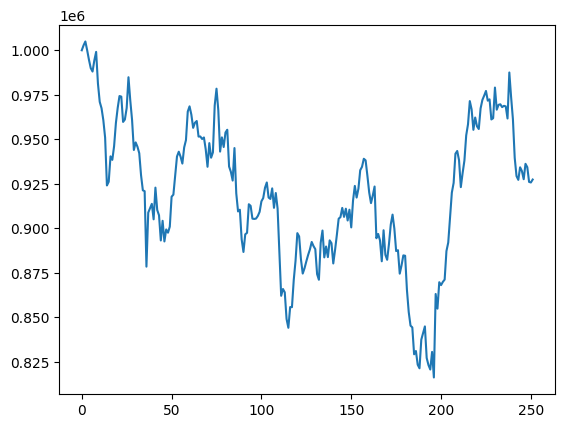

In [15]:
%matplotlib inline
df_account_value.account_value.plot()

## 7.1 BackTestStats

pass in df_account_value, this information is stored in env class

In [16]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value,)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all

==============Get Backtest Results===========
Annual return         -0.072574
Cumulative returns    -0.072574
Annual volatility      0.188341
Sharpe ratio          -0.307848
Calmar ratio          -0.386629
Stability              0.062765
Max drawdown          -0.187710
Omega ratio            0.949587
Sortino ratio         -0.431646
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003084
Daily value at risk   -0.023959
dtype: float64


,0
Annual return,-0.072574
Cumulative returns,-0.072574
Annual volatility,0.188341
Sharpe ratio,-0.307848
Calmar ratio,-0.386629
Stability,0.062765
Max drawdown,-0.187710
Omega ratio,0.949587
Sortino ratio,-0.431646
Skew,NaN


In [17]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return         -0.088436
Cumulative returns    -0.088101
Annual volatility      0.185081
Sharpe ratio          -0.410029
Calmar ratio          -0.407645
Stability              0.243620
Max drawdown          -0.216945
Omega ratio            0.935511
Sortino ratio         -0.568133
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.966671
Daily value at risk   -0.023619
dtype: float64


In [18]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.008656e+06
2    2022-01-05  1.011041e+06
3    2022-01-06  1.002408e+06
4    2022-01-07  9.980177e+05
..          ...           ...
247  2022-12-27  9.147240e+05
248  2022-12-28  9.158399e+05
249  2022-12-29  9.091405e+05
250  2022-12-30  9.118987e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.008656e+06
2022-01-05  1.011041e+06
2022-01-06  1.002408e+06
2022-01-07  9.980177e+05
...                  ...
2022-12-27  9.147240e+05
2022-12-28  9.158399e+05
2022-12-29  9.091405e+05
2022-12-30  9.118987e+05
2023-01-03           NaN

[252 rows x 1 columns]


## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.002774e+06
2022-01-05  1.004937e+06
2022-01-06  1.000039e+06
2022-01-07  9.946651e+05
...                  ...
2022-12-27  9.362508e+05
2022-12-28  9.343567e+05
2022-12-29  9.260969e+05
2022-12-30  9.257754e+05
2023-01-03  9.274258e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.002774e+06  1.008656e+06
2022-01-05  1.004937e+06  1.011041e+06
2022-01-06  1.000039e+06  1.002408e+06
2022-01-07  9.946651e+05  9.980177e+05
...       

<Figure size 1500x500 with 0 Axes>

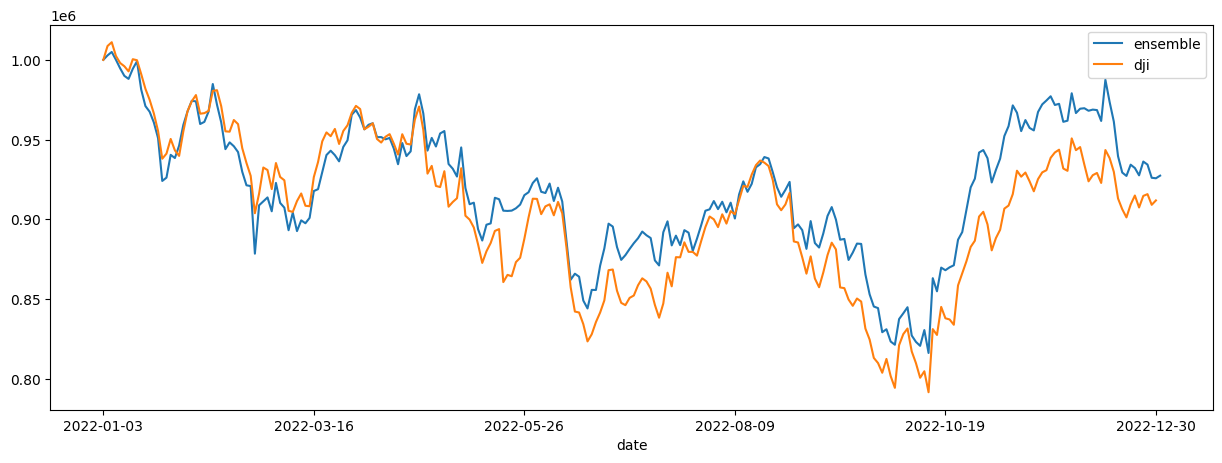

In [19]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();